In [11]:
%cd /Users/masha/Documents/visual-reasoning

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import timm
from sklearn.metrics import roc_auc_score, accuracy_score

/Users/masha/Documents/visual-reasoning


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dinov3 = timm.create_model(
    "vit_small_patch16_dinov3",
    pretrained=True
)

dinov3.to(device)
dinov3.eval()

# Ensure nothing is trainable
for p in dinov3.parameters():
    p.requires_grad = False

@torch.no_grad()
def embed(x):
    x = x.to(device)
    feats = dinov3.forward_features(x)  # (B, tokens, 384)
    
    # CLS token or mean-pooling — pick ONE and stick to it
    if feats.dim() == 3:
        feats = feats.mean(dim=1)        # global pooled
    
    return feats

In [ ]:
all_sims = []
all_labels = []

train_raw = np.load('./data/train_pairs.npy', allow_pickle=True)
test_raw = np.load('./data/test_balanced.npy', allow_pickle=True)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def prepare_data(raw_list, is_train=False):
    # Stack all images into one tensor (N, 1, 64, 64)
    x0 = torch.tensor(np.stack([d['x0'] for d in raw_list])).float()
    x1 = torch.tensor(np.stack([d['x1'] for d in raw_list])).float()
    
    # DINOv3 requires 3-channel input even for grayscale data
    x0 = x0.repeat(1, 3, 1, 1)
    x1 = x1.repeat(1, 3, 1, 1)
    
    # Normalize with respect to ImageNet for DINOv3
    x0 = (x0 + 1) * 0.5 
    x1 = (x1 + 1) * 0.5
    # print(x0, x1)
    
    # Apply ImageNet Normalization
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x0 = normalize(x0)
    x1 = normalize(x1)
    
    if is_train:
        y = torch.ones(len(raw_list))
    else:
        y = torch.tensor([1.0 if d.get('label') == 'same' else 0.0 for d in raw_list])
        
    return x0, x1, y

train_x0, train_x1, train_y = prepare_data(train_raw, is_train=True)
test_x0, test_x1, test_y = prepare_data(test_raw, is_train=False)

train_loader = DataLoader(TensorDataset(train_x0, train_x1, train_y), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_x0, test_x1, test_y), batch_size=32)

batch = next(iter(train_loader))
print(f"Batch Shape: {batch[0].shape}")
print(f"Label Shape: {batch[2].shape}")

with torch.no_grad():
    for x0, x1, y in test_loader:
        z0 = embed(x0)
        z1 = embed(x1)

        sims = F.cosine_similarity(z0, z1, dim=1)

        all_sims.append(sims.cpu())
        all_labels.append(y)

all_sims = torch.cat(all_sims).numpy()
all_labels = torch.cat(all_labels).numpy()


Batch Shape: torch.Size([32, 3, 64, 64])
Label Shape: torch.Size([32])


In [12]:
auc = roc_auc_score(all_labels, all_sims)
print("DINOv3 zero-shot ROC-AUC:", auc)

preds = (all_sims > 0.5).astype(int)
acc = accuracy_score(all_labels, preds)
print("Accuracy @ cos>0.5:", acc)


DINOv3 zero-shot ROC-AUC: 0.656147271531887
Accuracy @ cos>0.5: 0.5



--- DINOv3 Baseline Results ---
Mean Similarity (Same):      0.8285
Mean Similarity (Diff):      0.7967
Mean Distance (Same):      5.0883
Mean Distance (Diff):      5.5449
Baseline AUC Score from cosine similarity:          0.5970
Baseline AUC Score from Euclidean distance:        0.6003


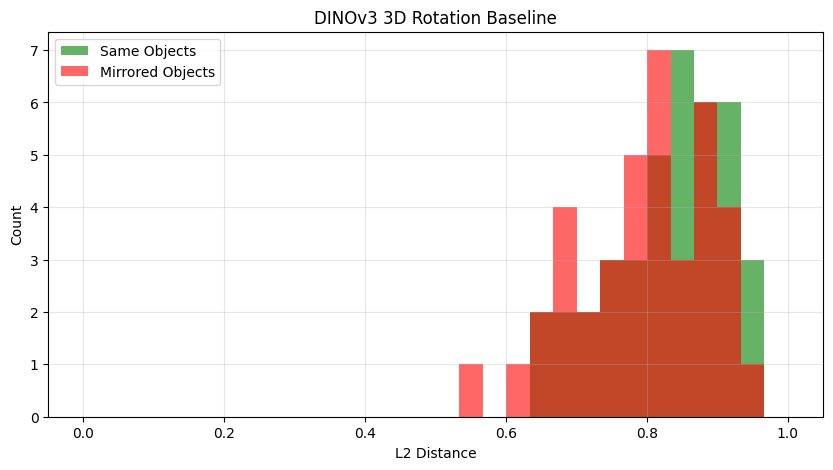

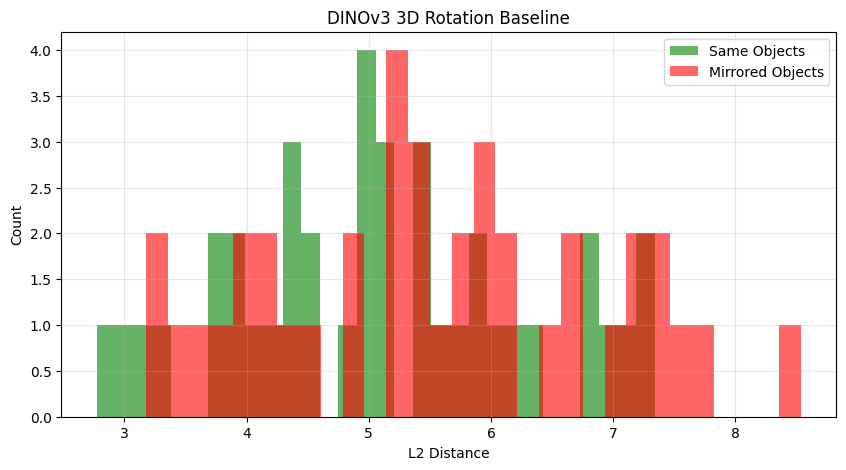

In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

test_raw = np.load('./data/test_balanced.npy', allow_pickle=True)

def prepare_baseline_data(raw_list):
    x0_np = np.stack([d['x0'] for d in raw_list])
    x1_np = np.stack([d['x1'] for d in raw_list])
    
    x0_t = torch.tensor(x0_np).float()
    x1_t = torch.tensor(x1_np).float()
    
    x0_t = F.interpolate(x0_t, size=(224, 224), mode='bilinear', align_corners=False)
    x1_t = F.interpolate(x1_t, size=(224, 224), mode='bilinear', align_corners=False)
    
    x0_t = x0_t.repeat(1, 3, 1, 1)
    x1_t = x1_t.repeat(1, 3, 1, 1)
    
    x0_t = (x0_t + 1) * 0.5 
    x1_t = (x1_t + 1) * 0.5
    
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x0_t = normalize(x0_t)
    x1_t = normalize(x1_t)
    
    y = torch.tensor([1.0 if d.get('label') == 'same' else 0.0 for d in raw_list])
    
    return x0_t, x1_t, y

x0, x1, y = prepare_baseline_data(test_raw)
test_loader = DataLoader(TensorDataset(x0, x1, y), batch_size=BATCH_SIZE)

dinov3 = timm.create_model("vit_small_patch16_dinov3", pretrained=True, num_classes=0)
dinov3.to(device)
dinov3.eval()

sim_scores_same = []
sim_scores_diff = []
cos_labels = []
all_scores = []

dist_same = []
dist_diff = []
dist_labels = []
all_dists = []

with torch.no_grad():
    for bx0, bx1, by in test_loader:
        bx0, bx1 = bx0.to(device), bx1.to(device)
        
        # Extract features (CLS Token)
        # forward_features returns (B, N, D). Index 0 is CLS.
        feats0 = dinov3.forward_features(bx0)[:, 0, :]
        feats1 = dinov3.forward_features(bx1)[:, 0, :]
        
        # Compute cosine similarity
        similarity = F.cosine_similarity(feats0, feats1, dim=1).cpu().numpy()
        # Compute l2 norm directly on embeddings from dinov3
        feat_distance = torch.norm(feats0 - feats1, p=2, dim=1).cpu().numpy()
        
        labels = by.numpy()
        
        for i in range(len(labels)):
            score = similarity[i]
            lbl = labels[i]
            
            all_scores.append(score)
            cos_labels.append(lbl)
            
            if lbl == 1.0:
                sim_scores_same.append(score)
            else:
                sim_scores_diff.append(score)

        for i in range(len(labels)):
            d = feat_distance[i]
            lbl = labels[i]
            
            all_dists.append(d)
            dist_labels.append(lbl)
            
            if lbl == 1.0:
                dist_same.append(d)
            else:
                dist_diff.append(d)

sim_scores_same = np.array(sim_scores_same)
sim_scores_diff = np.array(sim_scores_diff)

dist_same = np.array(dist_same)
dist_diff = np.array(dist_diff)

print(f"\n--- DINOv3 Baseline Results ---")
print(f"Mean Similarity (Same):      {np.mean(sim_scores_same):.4f}")
print(f"Mean Similarity (Diff):      {np.mean(sim_scores_diff):.4f}")

print(f"Mean Distance (Same):      {np.mean(dist_same):.4f}")
print(f"Mean Distance (Diff):      {np.mean(dist_diff):.4f}")

# Calculate AUC
auc = roc_auc_score(cos_labels, all_scores)
print(f"Baseline AUC Score from cosine similarity:          {auc:.4f}")

auc = roc_auc_score(dist_labels, -np.array(all_dists))
print(f"Baseline AUC Score from Euclidean distance:        {auc:.4f}")

# Visualization
plt.figure(figsize=(10, 5))
plt.hist(sim_scores_same, bins=30, alpha=0.6, label='Same Objects', color='green', range=(0, 1))
plt.hist(sim_scores_diff, bins=30, alpha=0.6, label='Mirrored Objects', color='red', range=(0, 1))
plt.title("DINOv3 3D Rotation Baseline")
plt.xlabel("L2 Distance")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(dist_same, bins=30, alpha=0.6, label='Same Objects', color='green')
plt.hist(dist_diff, bins=30, alpha=0.6, label='Mirrored Objects', color='red')
plt.title("DINOv3 3D Rotation Baseline")
plt.xlabel("L2 Distance")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()